Problem statement: 

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
### Read the data from Google Drive - Mount the drive

In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Importing all the important libraries

In [3]:
import pathlib
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping 

from tensorflow.keras.preprocessing.image import load_img

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

*   List item
*   List item



In [7]:
## Write your train dataset here
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,shuffle=True,seed=123, 
                                                       batch_size=batch_size,image_size=(img_height, img_width),
                                                       validation_split= 0.2,
                                                       subset= 'training',
                                                       label_mode='categorical')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,shuffle=True,seed=123, 
                                                       batch_size=batch_size,image_size=(img_height, img_width),
                                                       validation_split= 0.2,
                                                       subset= 'validation',
                                                       label_mode='categorical')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data


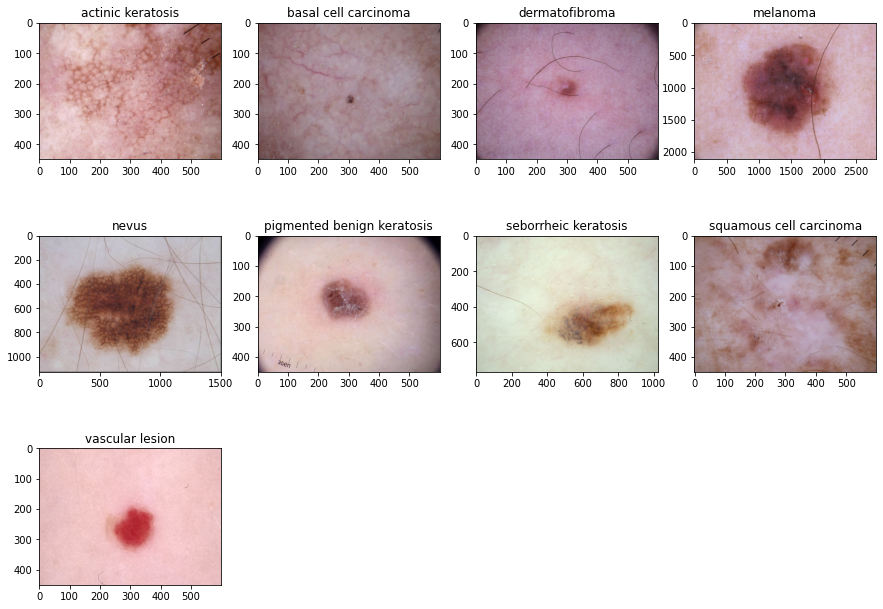

In [10]:
# Since 10 classes we will create a loop through the classes to view the images
plt.figure(figsize=[15,15])
for i in range(9):
  plt.subplot(4,4,i+1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+ '/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
from keras.layers import Dense, Dropout, Flatten, MaxPool2D, Conv2D, Activation, BatchNormalization

In [13]:
# Creating the model
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))])
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='same',input_shape=(img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(5,5),padding='same',input_shape=(img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(Conv2D(filters=64,kernel_size=(5,5)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes)) 
model.add(Activation('softmax'))




```
# This is formatted as code
```

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Compile the model
model.compile(optimizer='sgd',loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 activation_1 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                        

### Train the model

In [16]:
# Train the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 330s 1s/step - loss: 2.0618 - accuracy: 0.2003 - val_loss: 2.0501 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 5s 98ms/step - loss: 2.0045 - accuracy: 0.2455 - val_loss: 1.9286 - val_accuracy: 0.2573
Epoch 3/20
56/56 [==============================] - 5s 98ms/step - loss: 1.9708 - accuracy: 0.2701 - val_loss: 1.8581 - val_accuracy: 0.3669
Epoch 4/20
56/56 [==============================] - 5s 98ms/step - loss: 2.0256 - accuracy: 0.2266 - val_loss: 1.9830 - val_accuracy: 0.2483
Epoch 5/20
56/56 [==============================] - 5s 98ms/step - loss: 1.9582 - accuracy: 0.2662 - val_loss: 1.8890 - val_accuracy: 0.2931
Epoch 6/20
56/56 [==============================] - 5s 98ms/step - loss: 1.9245 - accuracy: 0.2857 - val_loss: 1.9113 - val_accuracy: 0.3154
Epoch 7/20
56/56 [==============================] - 6s 98ms/step - loss: 1.8764 - accuracy: 0.3075 - val_loss: 1.8620 - val_accuracy: 0.2908
Epoch 8/20
56

### Visualizing training results

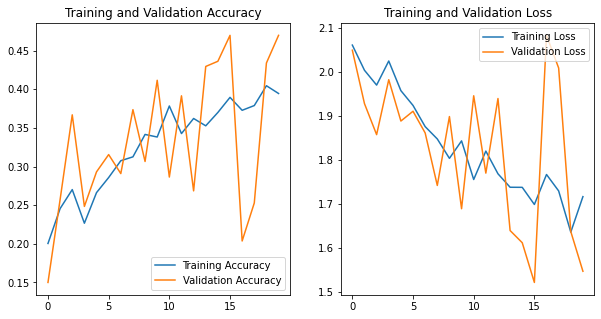

In [17]:
# plot the results of trained model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings -

* The model is underfitting  - Accuracy 44% on the training dataset
* Also the accuracy keeps varying in both train and test datasets which displays model is fluctuating in determining based on the current features learnt.

In [18]:
# Since this deals with images, lets try to see if rotating and flipping of images as the data augumentation 
data_augument = keras.Sequential([layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

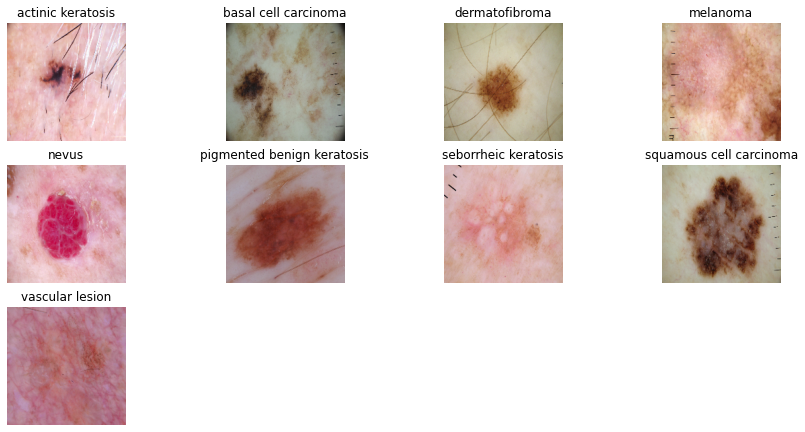

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis('off')

### Todo:
### Create the model, compile and train the model


In [20]:
## In the first model, dropout was added to last layer. In this case we can add drop out to both layers and reduce the kernel size to 3,3
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))])

# First convolution layer
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',input_shape=(img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Second convolution layer
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=(img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(Conv2D(filters=64,kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten the layer
model.add(Flatten())

# Dense layer with softmax
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [21]:
# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_5 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 activation_6 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                      

### Compiling the model

In [22]:
# Compile the model 2 - Use Adam optimizer this time
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

### Training the model

In [23]:
# Train the model 
epochs=20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 7s 87ms/step - loss: 2.2087 - accuracy: 0.2042 - val_loss: 2.0306 - val_accuracy: 0.2886
Epoch 2/20
56/56 [==============================] - 4s 76ms/step - loss: 1.8647 - accuracy: 0.3153 - val_loss: 1.7085 - val_accuracy: 0.4206
Epoch 3/20
56/56 [==============================] - 4s 76ms/step - loss: 1.6452 - accuracy: 0.4018 - val_loss: 1.6950 - val_accuracy: 0.4094
Epoch 4/20
56/56 [==============================] - 4s 76ms/step - loss: 1.5739 - accuracy: 0.4297 - val_loss: 1.5485 - val_accuracy: 0.4430
Epoch 5/20
56/56 [==============================] - 4s 76ms/step - loss: 1.5014 - accuracy: 0.4682 - val_loss: 1.4669 - val_accuracy: 0.4787
Epoch 6/20
56/56 [==============================] - 4s 78ms/step - loss: 1.4330 - accuracy: 0.4955 - val_loss: 1.4298 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 4s 77ms/step - loss: 1.3759 - accuracy: 0.5151 - val_loss: 1.4496 - val_accuracy: 0.5280
Epoch 8/20
56

### Visualizing the results

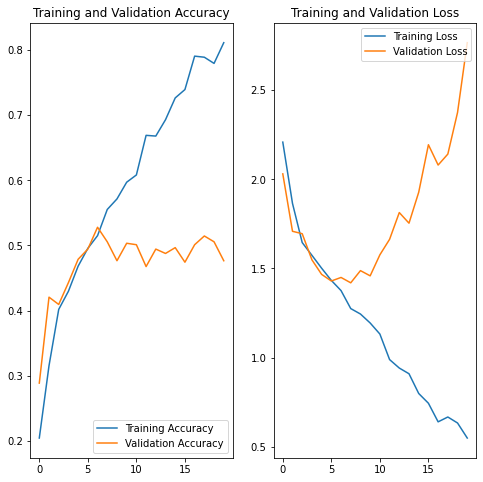

In [24]:
# Plot the results of the trained model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### The previous model was underfitting. This model is evidently overfitting.
* The train accuracy is 84% but validation accuracy is 50% which is cleary indicating that model is overfitting. 
* We should check for the distribution in the data to determine the reason for overfit.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

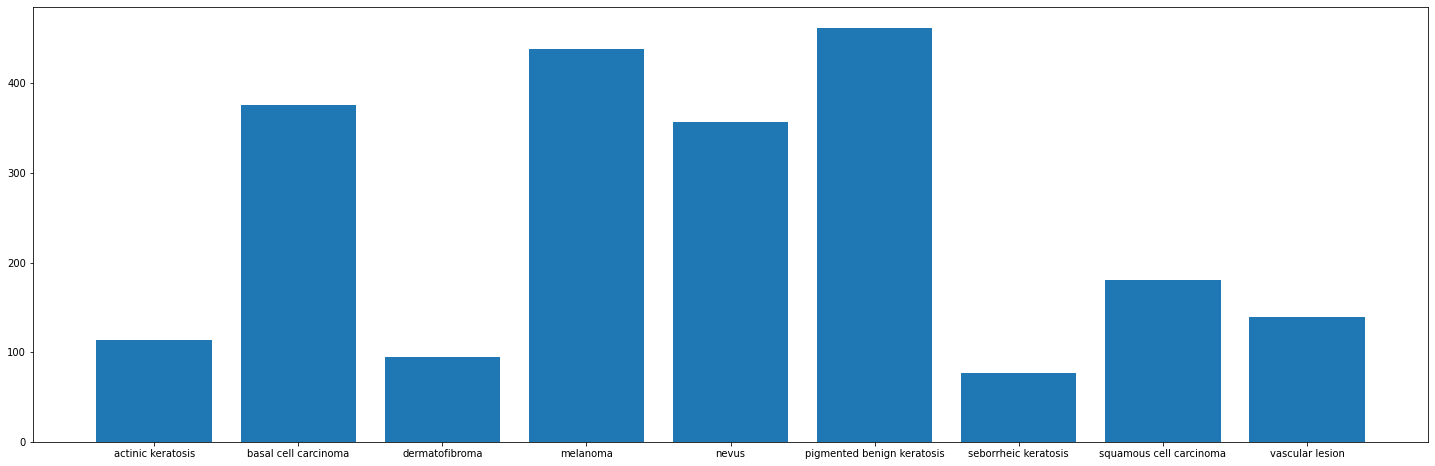

In [25]:
# Distribution of classes in the train dataset
count=[]

# Plot a bar graph listing the distribution of different classes of cancer
for x in class_names:
    count.append(len(list(data_dir_train.glob(x+'/*.jpg'))))
plt.figure(figsize=(25,8))
plt.bar(class_names,count)

#### - Which class has the least number of samples?
* Seborrheic Keratosis has the least number of Sample



#### - Which classes dominate the data in terms proportionate number of samples?
* Pigmented Benign Keratosis, Melanoma has propotionate number of samples.
* Basal cell carcinoma, nevus has propotionate number of samples.
* Squamous cell carcinoma, Vascular lesion has propotionate number of samples

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
# Use augumentation
path_to_training_dataset="/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EFFF6641BE0>: 100%|██████████| 500/500 [00:20<00:00, 24.19 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F000C1D64F0>: 100%|██████████| 500/500 [00:22<00:00, 22.17 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F000C4BBAF0>: 100%|██████████| 500/500 [00:17<00:00, 28.16 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EFFF669B610>: 100%|██████████| 500/500 [01:25<00:00,  5.87 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F00607A3100>: 100%|██████████| 500/500 [01:14<00:00,  6.71 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0064172220>: 100%|██████████| 500/500 [00:17<00:00, 28.13 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F000C21CD30>: 100%|██████████| 500/500 [00:39<00:00, 12.66 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0064059580>: 100%|██████████| 500/500 [00:16<00:00, 29.54 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFFF6772D90>: 100%|██████████| 500/500 [00:18<00:00, 27.54 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
# List the count of images after Augumetor processing 
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
# Create path list and lesion list for the original dataframe
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)

# Create the original dataframe
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/Colab Notebooks/Skin ...,actinic keratosis
1,/content/gdrive/My Drive/Colab Notebooks/Skin ...,actinic keratosis
2,/content/gdrive/My Drive/Colab Notebooks/Skin ...,actinic keratosis
3,/content/gdrive/My Drive/Colab Notebooks/Skin ...,actinic keratosis
4,/content/gdrive/My Drive/Colab Notebooks/Skin ...,actinic keratosis
...,...,...
2234,/content/gdrive/My Drive/Colab Notebooks/Skin ...,vascular lesion
2235,/content/gdrive/My Drive/Colab Notebooks/Skin ...,vascular lesion
2236,/content/gdrive/My Drive/Colab Notebooks/Skin ...,vascular lesion
2237,/content/gdrive/My Drive/Colab Notebooks/Skin ...,vascular lesion


In [30]:
# Define the dataset path 
data_dir_train1 = pathlib.Path("/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

0


In [31]:
# Create a new path list.
for i in class_names:
      
    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)

# Create the new dataframe with augumented images added 
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/gdrive/My Drive/Colab Notebooks/Skin ...,actinic keratosis
1,/content/gdrive/My Drive/Colab Notebooks/Skin ...,actinic keratosis
2,/content/gdrive/My Drive/Colab Notebooks/Skin ...,actinic keratosis
3,/content/gdrive/My Drive/Colab Notebooks/Skin ...,actinic keratosis
4,/content/gdrive/My Drive/Colab Notebooks/Skin ...,actinic keratosis
...,...,...
2234,/content/gdrive/My Drive/Colab Notebooks/Skin ...,vascular lesion
2235,/content/gdrive/My Drive/Colab Notebooks/Skin ...,vascular lesion
2236,/content/gdrive/My Drive/Colab Notebooks/Skin ...,vascular lesion
2237,/content/gdrive/My Drive/Colab Notebooks/Skin ...,vascular lesion


In [32]:
# Print the value counts
new_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [33]:
# Set the batch size, image shape
batch_size = 32
img_height = 180
img_width = 180

In [34]:
# Define the path 
data_dir_train1 = pathlib.Path("/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

In [35]:
# Print the count of images
image_count_train1 = len(list(data_dir_train1.glob('*/output/*.jpg')))
print(image_count_train1)

4500


#### **Todo:** Create a training dataset

In [36]:
# Define the train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [37]:
# Define the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [38]:
# Create the model - Retaining Dropout and adding batch normalization
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))])

# First convolution layer
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',input_shape=(img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Second convolution layer
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=(img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(Conv2D(filters=64,kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.40))

# Flatten the layer
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.5))

# Dense layer with softmax
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
# Compile the model 
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### **Todo:**  Train your model

In [40]:
# Set epochs to 50
epochs =50

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/50
169/169 [==============================] - 44s 252ms/step - loss: 43.6050 - accuracy: 0.3218 - val_loss: 34.7204 - val_accuracy: 0.0898
Epoch 2/50
169/169 [==============================] - 33s 188ms/step - loss: 12.0393 - accuracy: 0.4015 - val_loss: 8.9968 - val_accuracy: 0.2383
Epoch 3/50
169/169 [==============================] - 32s 185ms/step - loss: 7.3230 - accuracy: 0.4156 - val_loss: 13.8989 - val_accuracy: 0.2079
Epoch 4/50
169/169 [==============================] - 32s 184ms/step - loss: 4.4031 - accuracy: 0.4612 - val_loss: 5.3323 - val_accuracy: 0.3504
Epoch 5/50
169/169 [==============================] - 34s 193ms/step - loss: 3.1382 - accuracy: 0.4968 - val_loss: 7.7313 - val_accuracy: 0.3311
Epoch 6/50
169/169 [==============================] - 34s 193ms/step - loss: 2.4011 - accuracy: 0.5349 - val_loss: 2.2541 - val_accuracy: 0.5479
Epoch 7/50
169/169 [==============================] - 32s 185ms/step - loss: 1.9081 - accuracy: 0.5942 - val_loss: 3.8429 - va

#### **Todo:**  Visualize the model results

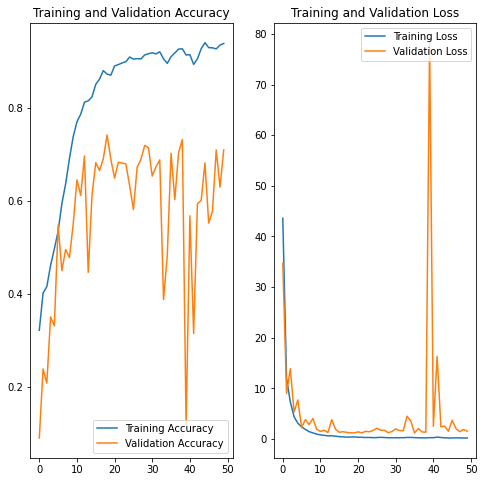

In [41]:
# Plot the validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

* The model is still overfitting with training accuracy of 93% and validation accuracy of 70% on the 50th Epoch.
* There is no great change in validation accuracy beyond 74% after 19th Epoch
* Validation loss is higher around 38th Epoch.
* Data Augmentation increased the accuracy of training set slightly. 
* Class rebalance was of not much help as the model is still overfitting
* Model overfitting can be addressed further by adding more layers and tuning hyperparameters



### Model Prediction - One example

1/1 [==============================] - 0s 304ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


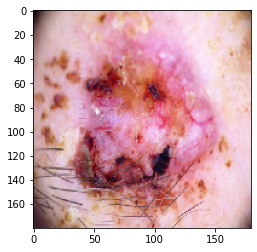

In [44]:
# Print a prediction made
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob.glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )